In [1]:
## Playing with Party-Level data

In [2]:
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)
# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)
# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import pickle, os, gc, re, sys

sns.set();
sns.set_palette("colorblind")

from IPython.display import display, display_html, HTML
from IPython.core.debugger import set_trace
# plt.rcParams["axes.grid"] = False

import Jupyter_module_loader
# sys.path.insert(1, '/path/to/application/app/folder')
from utility import *
# import gaussian_kde

# import warnings
# warnings.filterwarnings('ignore')

import holoviews as hv
from holoviews import opts

encoding = "ISO-8859-1"

# you should clone this git to a subdirectory called 'BES_analysis_code' (in some directory - I call it BES_analysis - doesn't matter though)
# %matplotlib inline



Toggle code

In [3]:
dataset_folder = "C:\\Users\\Marios\\Documents\\GitHub\\Thomas Prosser project\\datasets\\"
output_folder = "C:\\Users\\Marios\\Documents\\GitHub\\Thomas Prosser project\\output\\"


In [4]:
df_corrs_ni_nm = pd.read_pickle(dataset_folder+"Party Level"+os.sep+ "df_corrs_ni_nm.zip",compression='zip')
df = pd.read_pickle(dataset_folder+"Party Level"+os.sep+ "df.zip",compression='zip')
df_merged = pd.read_pickle(dataset_folder+"Party Level"+os.sep+ "df_merged.zip",compression='zip')

In [5]:
Treatment = "Party Level Data Decomposition"
output_subfolder = output_folder + Treatment + os.sep
if not os.path.exists( output_subfolder ):
    os.makedirs( output_subfolder )

In [6]:
df_merged.dtypes.value_counts()

float64    1081
float32     105
int64         1
dtype: int64

In [7]:
grouped_party_data = df_merged.select_dtypes('number').copy()
grouped_party_data = grouped_party_data.fillna(grouped_party_data.mean())

decomp_index = grouped_party_data.index
decomp_columns = grouped_party_data.columns
clean_feature_set_std = StandardScaler().fit_transform(grouped_party_data.values )
decomp_std = pd.DataFrame(   clean_feature_set_std,
                             columns = decomp_columns,
                             index   = decomp_index  )

In [13]:
%%time
# 5 mins
## RUN (some variant of) PCA (potentially v slow!)
n_components = decomp_std.shape[1]
n_components = 8
# (svd_solver='full', n_components='mle',whiten=True)
# decomp = PCA(n_components = n_components,svd_solver='full')
# decomp = FastICA(algorithm='deflation', fun='exp', fun_args=None, max_iter=1000,
#     n_components=None, random_state=None, tol=0.07, w_init=None, whiten=False) # 2h 1min 4s "fast"
# decomp = SparsePCA(n_components=n_components, alpha=2,max_iter=1000,n_jobs=4,tol=1e-10, verbose=True) # 5min
#
# alpha=2 -> 1hr

decomp = FactorAnalysis(svd_method = 'lapack',n_components = n_components) ## ~10s ,n_components=30 -> 1.5 hrs
decomp_method = str(decomp).split("(")[0] 
# ,n_components=30

X_r = decomp.fit_transform(decomp_std)

BES_decomp = pd.DataFrame(   X_r,
                             columns = range(0,n_components),
                             index   = decomp_index)


Wall time: 1min 50s


In [14]:
import pickle
# treatdir = BES_data_folder+Treatment
# subdir = BES_data_folder+Treatment+decomp_method
load_suff = "FactorAnalysis"
save = True # False => Load

if save & ( 'decomp' in globals() ): # SAVE    ##( 'decomp' not in globals() )
    decomp_method = str(decomp).split("(")[0] 
    subdir = output_subfolder + decomp_method
    fname = subdir+ os.sep + decomp_method
    # create dir, save decomp object, BES_decomp, BES_std    
    if not os.path.exists(subdir): os.makedirs(subdir)
    with open(fname+".pkl", "wb") as f: pickle.dump( decomp, f )
    BES_decomp.to_hdf(fname+".hdf"        , decomp_method)
    decomp_std.to_hdf(   fname+"_std"+".hdf" , decomp_method)
    
else: # LOAD decomp results (default is SAVE)
    decomp_method = load_suff
    subdir = output_subfolder + os.sep + decomp_method    
    fname = subdir + os.sep + decomp_method
    if not os.path.exists(subdir): raise Exception(subdir + ' does not exist!')
    # load decomp object, BES_decomp, BES_std, n_components
    with open(fname+".pkl", "rb") as f: decomp = pickle.load(f) 
    BES_decomp = pd.read_hdf(fname+".hdf")
    decomp_std    = pd.read_hdf(fname+"_std"+".hdf")
    n_components = decomp.components_.shape[0] 

Warning, filename truncated because it was over 30. Filenames may no longer be unique


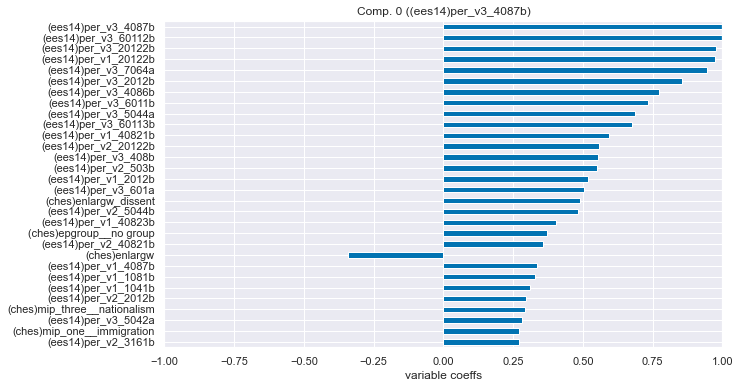

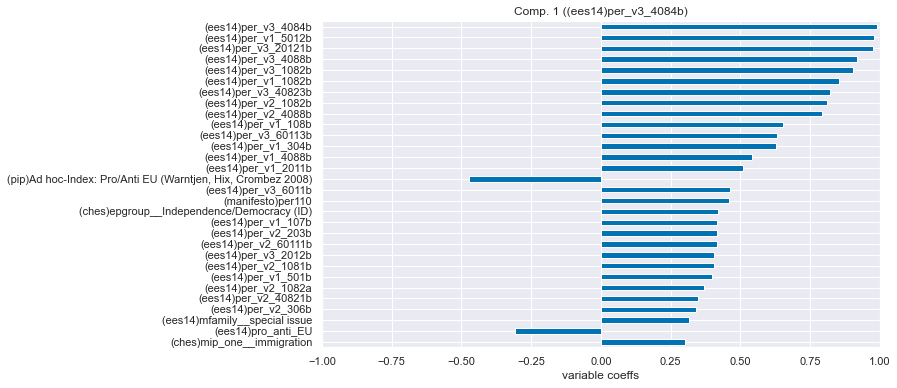

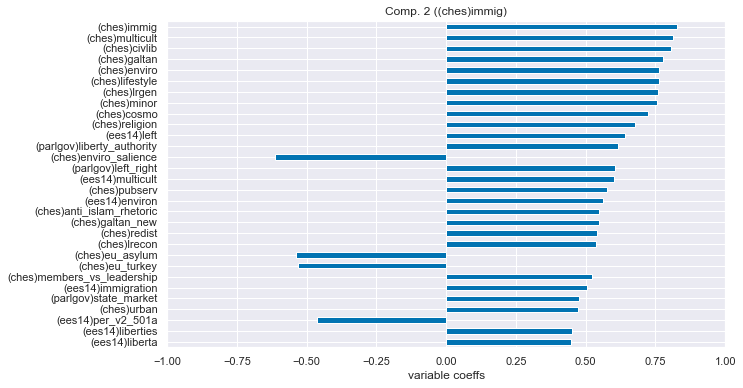

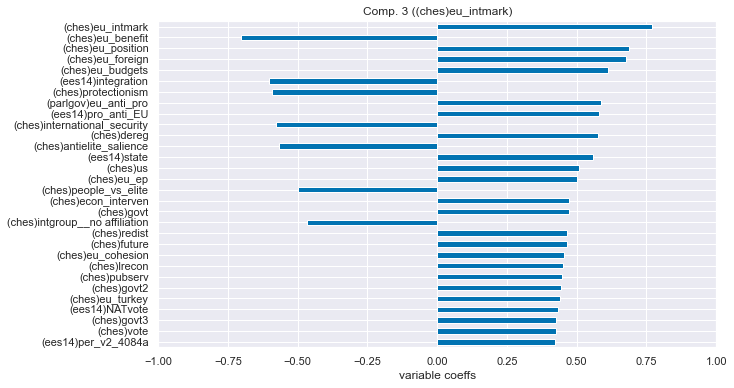

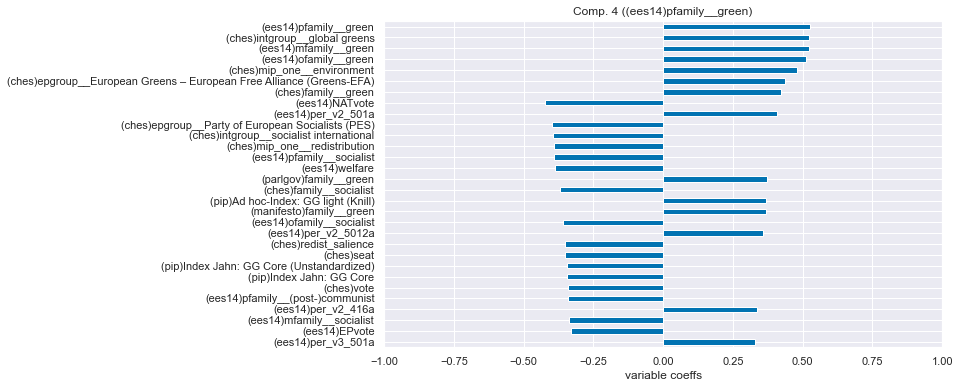

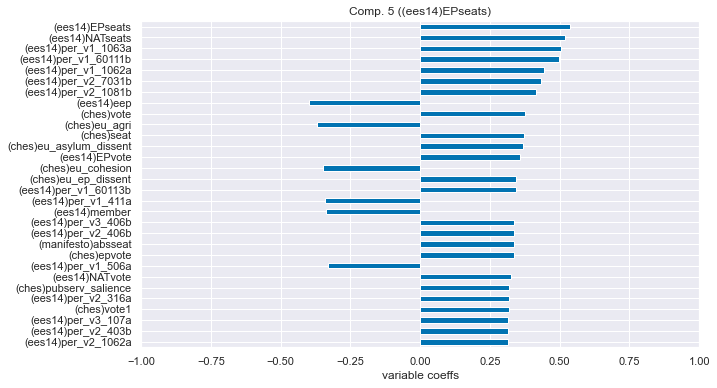

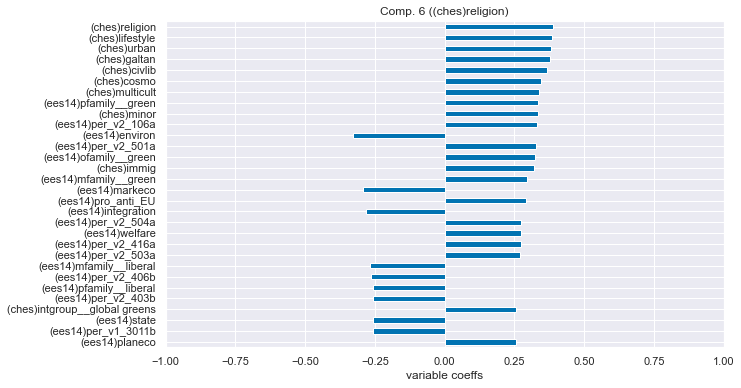

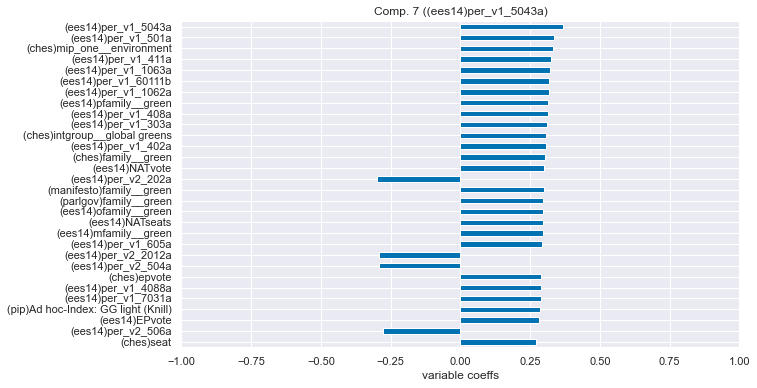

In [15]:
(BES_decomp, comp_labels, comp_dict) = display_components(n_components, decomp,
                                                          decomp_columns, BES_decomp, manifest=None, 
                                                          save_folder = subdir,  
                                                          show_first_x_comps= 8, show_histogram = False)

Automatically created module for IPython interactive environment
best n_components by PCA CV = 5
best n_components by FactorAnalysis CV = 5
best n_components by PCA MLE = 5
best n_components by PCA CV = 18
best n_components by FactorAnalysis CV = 5
best n_components by PCA MLE = 17


ValueError: math domain error

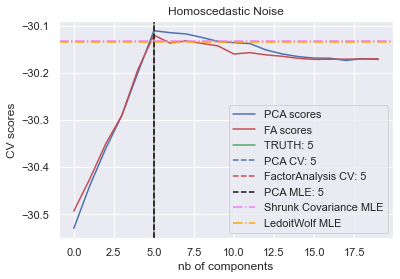

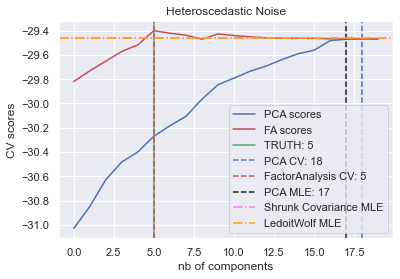

In [11]:
%%time
# Authors: Alexandre Gramfort
#          Denis A. Engemann
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.covariance import ShrunkCovariance, LedoitWolf
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

print(__doc__)

# #############################################################################
# Create the data

n_samples, n_features, rank = 1000, 20, 5
sigma = 1.
rng = np.random.RandomState(42)
U, _, _ = linalg.svd(rng.randn(n_features, n_features))
X = np.dot(rng.randn(n_samples, rank), U[:, :rank].T)

# Adding homoscedastic noise
X_homo = X + sigma * rng.randn(n_samples, n_features)

# Adding heteroscedastic noise
sigmas = sigma * rng.rand(n_features) + sigma / 2.
X_hetero = X + rng.randn(n_samples, n_features) * sigmas

# #############################################################################
# Fit the models

n_components = np.arange(0, n_features, 1)  # options for n_components


def compute_scores(X):
    pca = PCA(svd_solver='full')
    fa = FactorAnalysis()

    pca_scores, fa_scores = [], []
    for n in n_components:
        pca.n_components = n
        fa.n_components = n
        pca_scores.append(np.mean(cross_val_score(pca, X)))
        fa_scores.append(np.mean(cross_val_score(fa, X)))

    return pca_scores, fa_scores


def shrunk_cov_score(X):
    shrinkages = np.logspace(-2, 0, 30)
    cv = GridSearchCV(ShrunkCovariance(), {'shrinkage': shrinkages})
    return np.mean(cross_val_score(cv.fit(X).best_estimator_, X))


def lw_score(X):
    return np.mean(cross_val_score(LedoitWolf(), X))


decomp_index = grouped_party_data.index
decomp_columns = grouped_party_data.columns
clean_feature_set_std = StandardScaler().fit_transform(grouped_party_data.values )
decomp_std = pd.DataFrame(   clean_feature_set_std,
                             columns = decomp_columns,
                             index   = decomp_index     )


for X, title in [(X_homo, 'Homoscedastic Noise'),
                 (X_hetero, 'Heteroscedastic Noise'),
                 (decomp_std.values, 'Manifesto Project')]:
    pca_scores, fa_scores = compute_scores(X)
    n_components_pca = n_components[np.argmax(pca_scores)]
    n_components_fa = n_components[np.argmax(fa_scores)]

    pca = PCA(svd_solver='full', n_components='mle')
    pca.fit(X)
    n_components_pca_mle = pca.n_components_

    print("best n_components by PCA CV = %d" % n_components_pca)
    print("best n_components by FactorAnalysis CV = %d" % n_components_fa)
    print("best n_components by PCA MLE = %d" % n_components_pca_mle)

    plt.figure()
    plt.plot(n_components, pca_scores, 'b', label='PCA scores')
    plt.plot(n_components, fa_scores, 'r', label='FA scores')
    if title in [ 'Homoscedastic Noise','Heteroscedastic Noise']:
        plt.axvline(rank, color='g', label='TRUTH: %d' % rank, linestyle='-')
    plt.axvline(n_components_pca, color='b',
                label='PCA CV: %d' % n_components_pca, linestyle='--')
    plt.axvline(n_components_fa, color='r',
                label='FactorAnalysis CV: %d' % n_components_fa,
                linestyle='--')
    if title in [ 'Homoscedastic Noise','Heteroscedastic Noise']:    
        plt.axvline(n_components_pca_mle, color='k',
                label='PCA MLE: %d' % n_components_pca_mle, linestyle='--')

    # compare with other covariance estimators
    plt.axhline(shrunk_cov_score(X), color='violet',
                label='Shrunk Covariance MLE', linestyle='-.')
    plt.axhline(lw_score(X), color='orange',
                label='LedoitWolf MLE' % n_components_pca_mle, linestyle='-.')

    plt.xlabel('nb of components')
    plt.ylabel('CV scores')
    plt.legend(loc='lower right')
    plt.title(title)

plt.show()

In [12]:
grouped_party_data.shape, grouped_party_data.drop_duplicates().shape

((1258, 1187), (1256, 1187))